# Вариационный автокодировщик

tl;dr: Вместо тождественного отображения вариационны автокодировщик выучивает вероятностую модель данных. Стохастическия вычисления и априорное распределение кодов дополнительно регуляризуют модель.

In [1]:
import time

import numpy as np
import theano
import theano.tensor as T
import lasagne

import matplotlib.pylab as plt
%matplotlib inline

from utils import load_dataset, iterate_minibatches
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

BATCH_SIZE = 20
HIDDEN_DIM = 2

num_epochs = 10

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

## Кратко о вариационных автокодировщиках

Рассмотрим вариационный автокодировщик для бинарных наблюдений. Вариационный автокодировщик состоит из генеративной модели наблюдений

\begin{align}
& p(x, z | \theta) = p(x | z, \theta) p(z) \\
& p(x | z, \theta) = \prod_{i = 1}^D p_i(z, \theta)^{x_i} (1 - p_i(z, \theta))^{1 - x_i} \\
& p(z) = \mathcal N(z | 0, I)
\end{align}

и приближенного апостериорного распределения

\begin{equation}
q(z | x, \phi) = \mathcal N(z | \mu(x, \phi), \operatorname{diag}(\sigma^2(x, \phi)))
\end{equation}

Для краткости все выкладки приводятся для одного наблюдения $x$, параметры распределений по возможности опускаются. Для набора данных при обучении используется среднее значение нижней оценки. Цель обучения - максимизировать нижнюю оценку на обоснованность

$$ \mathcal L(x, \theta, \phi) = \mathbb E_{q(z | x, \phi)} p(x | z, \theta) - \operatorname{KL}(q(z | x, \phi) || p(z )) = \mathbb E_{q(z | x, \phi)} \log \frac{p(x | z, \phi)p(z)}{q(z | x, \theta)} \rightarrow \max_{\theta, \phi} $$

Как было рассказано на лекции, на практике нижняя оценка приближается оценкой 

\begin{align*}
&\frac{1}{K} \sum_{k=1}^K \log \frac{p(x | z_k)p(z_k)}{q(z_k | x)} \\
& \\
&z_k = \mu(x, \phi) + \sigma^2(x, \phi)^T \varepsilon_k \\
&\varepsilon_k \sim \mathcal N(0, I), iid
\end{align*}

с K=1, а затем максимизируется с помощью градиентного подъема.

## Как это реализовать?

Для вычисления приведенной выше нижней оценки необходимо уметь:
1. Вычислять логарифм плотности всех распределений ($p(x | z)$, $p(z)$, $q(z | x)$)
2. Сэмплировать из $q(z | x)$

Следуя практике *tensorflow.distributions*, мы реализуем распределения как два класса с методами *log_prob()* и *sample()*

In [2]:
class BinaryVector():
    def __init__(self, logits, rng=None):
        self.rng = rng if rng else RandomStreams(lasagne.random.get_rng().randint(1,2147462579))
        self.logits = logits

    def log_prob(self, x):
        # возвращает вектор вероятностей для каждого объекта в батче
        pixelwise_log_probs = (
            x * (self.logits - T.nnet.softplus(self.logits))
            - (1 - x) * T.nnet.softplus(self.logits)
        )
        return T.sum(pixelwise_log_probs, axis=(1, 2, 3))
    
    def sample(self):
        shape = self.logits.shape
        return T.nnet.sigmoid(self.logits) >= self.rng.uniform(shape)

In [11]:
class MultivariateNormalDiag():
    def __init__(self, loc=None, scale=None, rng=None):
        self.rng = rng if rng else RandomStreams(lasagne.random.get_rng().randint(1,2147462579))
        self.loc= loc
        self.scale = scale
    
    def log_prob(self, z):
        normalization_constant = (
            - 0.5 * np.log(2 * np.pi)
            - T.log(self.scale)
        )
        square_term = -0.5 * ((z - self.loc) / self.scale) ** 2
        log_prob_vec = normalization_constant + square_term
        return T.sum(log_prob_vec, axis=1)
    
    def sample(self):
        ######################################################################
        # Сэмплирование из q(z | x) - ключевой момент в вариационном автокоидровщике #
        # Пользуясь методом self.rng.normal() реализуйте её самостоятельно         #
        ######################################################################
        z0 = self.rng.normal(size=self.loc.shape)
        z = self.loc + self.scale * z0
        return z

Для параметров распределений построим две сети. Обратите внимание, что кодировщик теперь возвращает и код, и параметр масштаба

In [12]:
def vae_encoder_mlp(input_x):
    l_in = lasagne.layers.InputLayer(shape=(None, 1, 28, 28),
                                     input_var=input_x)
    ######################################################################################
    # Реализуйте некоторую несложную архитектуру кодировщика, возвращающую вектор среднего и вектор #
    # стандартных отклонений. Их размерность должны быть HIDDEN_DIM. Какие функции активаций ну-#
    # жно использовать?                                                                    #
    ######################################################################################
    net = lasagne.layers.DenseLayer(l_in, 120)
    net = lasagne.layers.DenseLayer(net, 50)
    net = lasagne.layers.DenseLayer(net, 10)
    l_out = lasagne.layers.DenseLayer(net, HIDDEN_DIM * 2, nonlinearity=None)
    l_out_loc = lasagne.layers.SliceLayer(l_out, slice(None, HIDDEN_DIM))
    l_out_scale = lasagne.layers.SliceLayer(l_out, slice(HIDDEN_DIM, None))
    l_out_scale = lasagne.layers.NonlinearityLayer(l_out_scale, nonlinearity=T.nnet.softplus)
    return l_out_loc, l_out_scale

def vae_decoder_mlp(input_z):
    l_in = lasagne.layers.InputLayer(shape=(None, 2),
                                     input_var=input_z)
    l_hid1 = lasagne.layers.DenseLayer(
            l_in, num_units=64,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(),
            name='d_hid1')
    l_hid2 = lasagne.layers.DenseLayer(
            l_hid1, num_units=128,
            nonlinearity=lasagne.nonlinearities.rectify,
            name='d_hid2')
    l_out = lasagne.layers.DenseLayer(
            l_hid2, num_units=28 ** 2,
            nonlinearity=None,
            name='d_out')
    l_out = lasagne.layers.ReshapeLayer(l_out, shape=(-1, 1, 28, 28))
    return l_out

## Строим граф вычислений 

Входы и модель вывода $q(z | x)$

In [14]:
input_x = T.tensor4('inputs')
#####################################################
# Определите encoder_mean, encoder scale, затем      #
# определите объект для апостериорного распределения qz_x  #
####################################################

encoder_mean, encoder_scale = vae_encoder_mlp(input_x)
rz_x = MultivariateNormalDiag(*lasagne.layers.get_output([encoder_mean, encoder_scale]))

Генеративная модель $p(x, z)$

In [16]:
###################################################################
# Определите параметр p(x | z) decoder_logits, затем                #
# определите объекты pz распределения p(z) и px_z распределения p(x | z) #
###################################################################
z = rz_x.sample()
decoder_logits = vae_decoder_mlp(z)
qz_x = rz_x.log_prob(z)
rx_z = BinaryVector(lasagne.layers.get_output(decoder_logits))
px_z = rx_z.log_prob(input_x)
p_z = MultivariateNormalDiag(0, 1).log_prob(z)

ELBO и правила для обновления весов

In [20]:
########################################################################################
# Пользуясь методами px_z, p_z, qz_x определите функцию потерь для вариационного автокодировщика #
# При обучении значение функции потерь должно принимать значения порядка -100 (от -150 и выше)   #
# Создайте список параметров сети для передачи в оптимизатор                                  #
# Что использовать в качестве функции потерь?                                               #
elbo = px_z.mean() - qz_x.mean() + p_z.mean()
params = lasagne.layers.get_all_params([decoder_logits, encoder_mean, encoder_scale])
loss = -elbo
########################################################################################
updates = lasagne.updates.adam(loss, params)

Определяем функции

In [21]:
train = theano.function(
    [input_x],
    elbo,
    updates=updates
)

elbo_at_test = theano.function(
    [input_x],
    elbo
)

И обучаем модель

In [22]:
for epoch in range(num_epochs):
    train_elbo = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, batchsize=BATCH_SIZE):
        """
        Обратите внимание, что тут предложенна вероятностная модель для бинарных данных.
        MNIST содержит черно-белые изображения с градациями серого.
        На практике при обучении автокодировщика получают бинарные данные, всякий раз положив случайно значение пикселя равным 0 или 1
        в зависимости от интенсивности пикселя в объекте из данных.
        Такой прием  называется динамическая бинаризация, он эффективно расширяет обучающую выборку и приводит к лучшим значениям 
        правдоподобия обученных моделей.
        """
        batch = np.random.rand(*batch.shape) <= batch
        train_elbo += train(batch)
        train_batches += 1
        
    test_elbo = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, batchsize=BATCH_SIZE):
        batch = np.random.rand(*batch.shape) <= batch
        test_elbo += elbo_at_test(batch)
        test_batches += 1
        
    print("Epoch {} of {} took {:.3f}s".format(
          epoch + 1, num_epochs, time.time() - start_time))
    print("Train error {}".format(train_elbo/train_batches))
    print("Test error {}".format(test_elbo/test_batches))

Epoch 1 of 10 took 22.165s
Train error -183.66964574692872
Test error -168.63429773459126
Epoch 2 of 10 took 20.747s
Train error -163.68269089287872
Test error -160.1281096927496
Epoch 3 of 10 took 22.170s
Train error -158.1499989115195
Test error -156.9929733330948
Epoch 4 of 10 took 24.474s
Train error -155.9965175619958
Test error -154.7403683454521
Epoch 5 of 10 took 25.389s
Train error -154.67799650868525
Test error -153.1991574451877
Epoch 6 of 10 took 26.182s
Train error -153.26439598956708
Test error -153.25883717314323
Epoch 7 of 10 took 26.220s
Train error -152.6488019126885
Test error -152.47243953199103
Epoch 8 of 10 took 26.616s
Train error -151.62723678026993
Test error -151.02709507521112
Epoch 9 of 10 took 28.631s
Train error -151.51834592478124
Test error -154.35701893673127
Epoch 10 of 10 took 29.791s
Train error -150.90615419987543
Test error -150.16776072900478


## Что получается? Визуализации

In [24]:
from utils import plot_reconstructions, plot_hidden_space

reconstruct = theano.function(
        [input_x],
        T.nnet.sigmoid(lasagne.layers.get_output(decoder_logits))
)

encode = theano.function(
        [input_x],
        rz_x.sample(),
)

Визуализируем среднее распределения $p(x | z)$

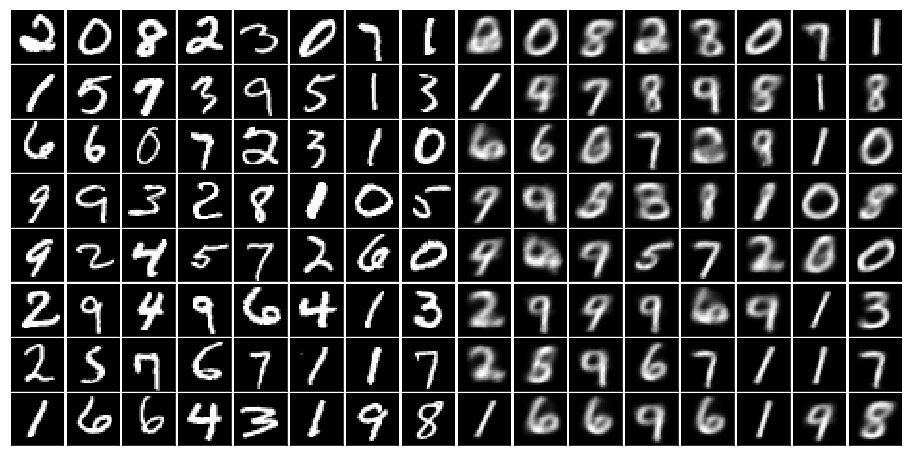

In [25]:
plot_reconstructions(X_test, reconstruct)

Чем отличается пространство представлений автокоидровщика от пространства представлений вариационного автокоидровщика? Почему возникло различие?

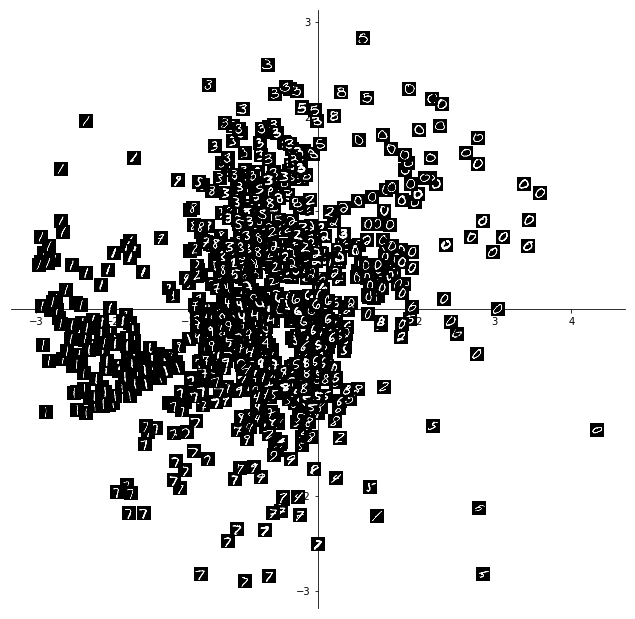

In [26]:
plot_hidden_space(X_test[:1000], encode)

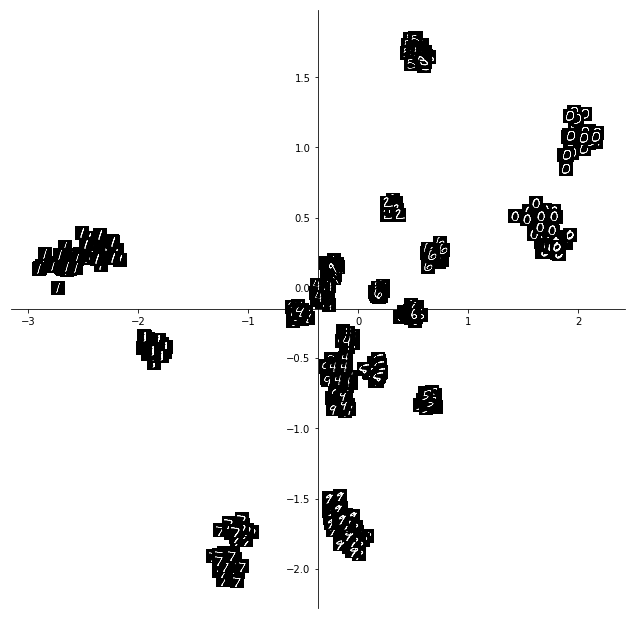

In [27]:
# рисуем по 25 сэмплов кода для каждого объекта
x_test_repeated = np.repeat(X_test[:25], repeats=25, axis=0)
plot_hidden_space(x_test_repeated, encode)